# Top End Assembly Vibration Study-- MTCamHexapod Telemetries

This notebook complements SITCOM-1485 and SITCOM-1486 providing MTM2 telemetries for the vibration event on March 10 2024

In [1]:
import sys, time, os, asyncio, glob
from datetime import datetime
import numpy as np
import pandas as pd 
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from lsst_efd_client import EfdClient
from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM2
from astropy.time import Time, TimeDelta
from scipy.fft import fft, fftfreq
from scipy.signal import detrend
from scipy.signal import get_window, welch


In [2]:
client = EfdClient('usdf_efd')

In [3]:
def calculate_fft_app(data1: DataFrame,
                      n: str | None) -> None:
    """Plot the position and frequency data.

    Parameters
    ----------
    data : `pandas.core.frame.DataFrame`
        EFD data.
    
#n: int | None

    """
    df = pd.DataFrame({'datetime': pd.to_datetime(data1.index)})
    #data["times"] = data.index
    #data["relative_time"] = data["times"] - data["times"].min()
    #data["relative_time"] = data["relative_time"].dt.total_seconds()
    timestamps =  df['datetime'].apply(lambda x: x.timestamp())
    timestamps = timestamps - timestamps.min()


    ##### FFT #######
    detrended_acc = detrend(data1[n])
    
    window = get_window("hamming", len(detrended_acc))
    windowed_acc = detrended_acc * window

    fft_acc = fft(windowed_acc)
    fft_freqs = fftfreq(
    len(windowed_acc),
    (timestamps[1] - timestamps[0]))

    positive_freqs = fft_freqs[: len(fft_freqs) // 2]
    positive_fft = np.abs(fft_acc[: len(fft_acc) // 2])

    max_freq = positive_freqs[positive_fft.argmax()]

    print(max_freq)

    return(max_freq, positive_freqs, positive_fft)    
    
   


In [4]:
# Select time window

# Whole weekend
#start = Time("2024-03-09T10:00:00Z", scale="utc", format="isot")
#end = Time("2024-03-11T06:00:00Z", scale="utc", format="isot")

 # Zoom on weaker vibrations
#start = Time("2024-03-10T18:00:00Z", scale="utc", format="isot")
#end = Time("2024-03-11T03:00:00Z", scale="utc", format="isot")

# Zoom on strong vibrations
name="Strong"
event="10 March 2024"
start = Time("2024-03-10T03:00:00Z", scale="utc", format="isot")
end = Time("2024-03-10T03:02:00Z", scale="utc", format="isot")

# non-vibration time - 2 min of data to be consistent. Aligned with SITCOM-1485 choice
#name="None"
#event="09 March 2024"
#start = Time("2024-03-09T10:00:00Z", scale="utc", format="isot")
#end = Time("2024-03-09T10:02:00Z", scale="utc", format="isot")


In [6]:
#select appropriate case

#efd_topic = "displacementSensors"
#efd_topic = "position"
efd_topic = "positionIMS"

#efd_variable = "Rotation"
efd_variable = "Position"

if efd_variable == "Rotation":
    all_columns = ["xRot", "yRot", "zRot"]
    units = "arcsec"
else:
    units = "um"
    if efd_topic == "displacementSensors":
        all_columns = ["deltaZ0", "deltaZ1", "deltaZ2", "deltaZ3", "deltaZ4", "deltaZ5"]
    else:
        all_columns = ["x", "y", "z"]

df = await client.select_time_series(
    f"lsst.sal.MTM2.{efd_topic}", 
    "*", 
    Time(start, format="isot", scale="utc"),
    Time(end, format="isot", scale="utc"), 
)

df = df.set_index("private_rcvStamp")
df.index = pd.to_datetime(df.index, unit="s")
data = df[all_columns]

# Convert microns to milimeters to make is easier to analyse
#df[all_columns] = df[all_columns] * 1e-3

# Convert arcsec to degrees
#df[all_columns] = df[all_columns] / 3600.

0.09493763710640597
0.4905111250497642
0.4905111250497642


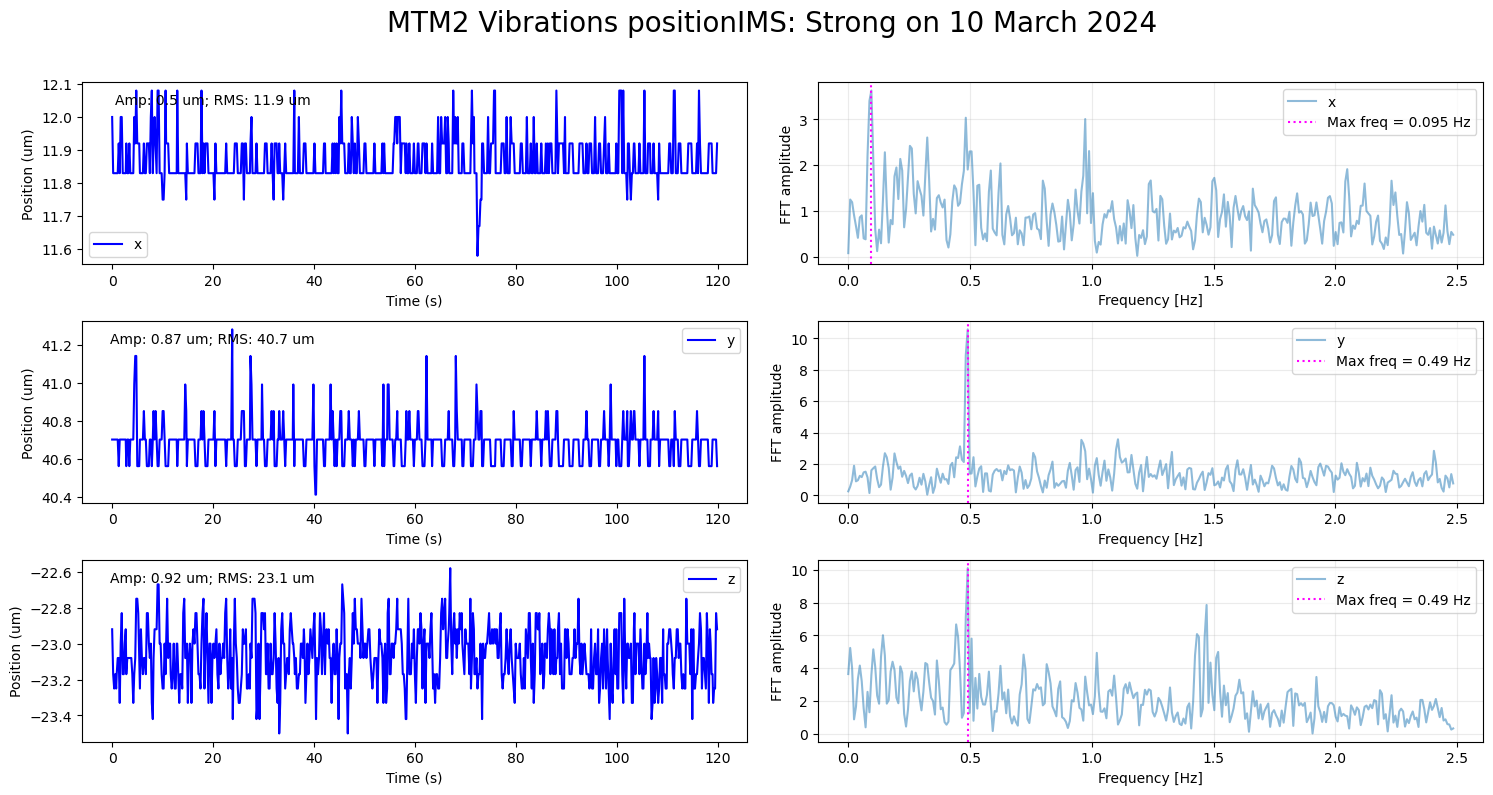

In [7]:
fig1 = plt.figure(figsize=(15,8))
ax = [None] * len(all_columns) * 2
gs = GridSpec(len(all_columns), 2, figure=fig1)

ax[0] = fig1.add_subplot(gs[0, 0])
ax[1] = fig1.add_subplot(gs[0, 1])

for i in range (2,len(ax)):
    if i % 2 == 0:
        ax[i] = fig1.add_subplot(gs[int(i/2), 0], sharex=ax[0])
    else:
        ax[i] = fig1.add_subplot(gs[int(i/2), 1], sharex=ax[1])

fig1.suptitle(f"MTM2 Vibrations {efd_topic}: {name} on {event}", fontsize=20)
fig1.tight_layout(pad=2) 

## Defining relative time in seconds -- Common to all the subplots
df = pd.DataFrame({'datetime': pd.to_datetime(data.index)})
    #data["times"] = data.index
    #data["relative_time"] = data["times"] - data["times"].min()
    #data["relative_time"] = data["relative_time"].dt.total_seconds()
timestamps =  df['datetime'].apply(lambda x: x.timestamp())
timestamps = timestamps - timestamps.min()

for i,axis in enumerate(all_columns):
    #------------- Position Plot --------------
    actual_position = np.array(data[axis])
    amp=float(np.ptp(actual_position)) # Amplitude
    rms=np.sqrt(np.mean(actual_position**2)) # RMS 
    ax[2*i].plot(timestamps, actual_position, "b")
    ax[2*i].set_xlabel("Time (s)")
    ax[2*i].set_ylabel(f"Position ({units})")
    ax[2*i].legend([str(axis)])
    ax[2*i].text(0.2, 0.9, f"Amp: {amp:.3} {units}; RMS: {rms:.3} {units} ", horizontalalignment='center',
     verticalalignment='center', transform=ax[2*i].transAxes)
    #------- Position FFT -------------------
    max_freq, positive_freqs, positive_fft= calculate_fft_app(data, str(axis))
    ax[2*i+1].plot(positive_freqs, positive_fft, label=str(axis), alpha=0.5)
    ax[2*i+1].axvline(max_freq,
                color='magenta', linestyle='dotted',
                label=f"Max freq = {max_freq:.2} Hz")
    ax[2*i+1].grid(":", alpha=0.25)
    ax[2*i+1].set_ylabel("FFT amplitude")
    ax[2*i+1].set_xlabel("Frequency [Hz]")
    ax[2*i+1].legend()

plt.savefig(f"mtm2_{efd_topic}_{efd_variable}_{name}.png")
plt.show()